# Mērījumu rezultātu analīze

## Mērķis
Fiksēt mērījumu rezultātu izmaiņu no ikdienas sitācijas (fikšet anomālijas)

Kā dati tiek izmantoti VAS ES monitoringa programmatūras SKUDRA radiofrekvenču spektra skenēšanas mērījumu rezultāti.
### Sagaidāmais rezultāts
Sagaidāmo rezultātu var iedalīt divos posmos:
1. iegūt grafisku pārskatu par radiofrekvenču spektra aktivitātes izmaiņu laikā
2. izstrādāt mašīnmācīšanās algoritmu, kas identificē vai nākošais mērījums atbilst ikdienas situācijai, vai tiek konstatēta novirze (anomālija), iegūt novirzes koeficientu.

## Dati
Dati atrodas uz servera http://skudra/ kur mērījumu meta dati glabājas MySQL datu bāzē, un mērījumu rezultāti (mērījumu laika dati) strukturēti direktorija TXT failos
Dati ir:
- timestamp (ms)
- frekvence (MHz)
- fiksētā limeņa vērtība (dBuV/m)
 Mērījumu rezultāti tiek iegūti pēc mērījuma ID, lai izgūtu datus ir iespējami 2 risinājumi:
 - veidot SQL pieprasījumu, kur iegūst katras frekvences mērījuma ID (parametrs_id), un pēc tā veidot http pieprasījumu, kur rezultāts būs json datu struktūra, kas satur *timestamp* un līmeni, frekvence ir iegūstama no SQL pieprasījuma.
 - piekļūstot *file storge* (uz servera esošu direktorija ar http pieprasījuma *backdoor* ;) ) pēc mērījuma id, un nolasot visus failus
 

## Datu tīrīšana/apstrāde
Veicot datu apstrādi jāņem vērā:
- *timestamp* ir novērota iznāma problēma, ka daži no tiem satur 12 simbolus un daži 13, lai iegūtu korektu laiku no ms, tad *timestamp* ir jāsatur 13 simbolus.
- Lai noteiktu signāla aktivitāti, nepiciešams izmantot signāla līmeni, gadijumos, kad singāla līmenis ir "-", nozīmē, ka konkrētajā skenēkjuma mērījumā dotajā frekvencē singāls netika konstatēts, līdz ar to vērtības "-" būtu jāaistāj ar *NaN*.
- Lai salīdzinātu signālu izmaiņu laikā, un samazinātu datu apjomu (datu apjoms var sasniegt pat vairākus GB), tad izvērtēšanai nepieciešams izmant datus, kas apkopoti pa 5 min.
- Lai korekti attēlotu signālu aktivitāti ir jāsalīdzina signlā aizņemtība, jo salīdzinot kādā konkrētā laikā fiksēto signālu skaitu nebūtu korekti, jo var atšķirties monitoringa programmatūras "SKUDRA" skenēšana cikla ātrums, signāla aizņemtību iegūst: fiksēto singālu skaits/mērījumu ciklu skaits * 100% konkrētajā laika intervālā.

## Datu iegūšana ar SQL pieprasījumiem
papildus izvērtēsim katras datu iegūšanas metodes ātrdarbību

In [7]:
import time
start_time = time.time()

import mysql.connector
import pandas as pd
import numpy as np
import json
import requests


# mysql piekļuves dati
with open('mysql_config.json') as f:
    mysql_config = json.load(f)

db = mysql.connector.connect(
    host=mysql_config['host'],
    user=mysql_config['user'],
    passwd=mysql_config['passwd'],
    db=mysql_config['db']
)

#mērījumu ID
event_ref=  10015730;
parameters = pd.read_sql_query("SELECT id, freq, count, files FROM `ss_parameters` WHERE `event_ref` = "+ str(event_ref), db)
parameters.set_index('id')
param = parameters[['id','freq', 'count', 'files']]
skaits= len(param)
df = pd.DataFrame()

#http://skudra/api/parameters/timelevel/{id}
for index, row in param.iterrows():
    print(f"{index} no  {skaits}| frekvences mērījuma id: {row['id']}, frekvence: {row['freq']}")
    uri = "http://skudra/api/parameters/timelevel/" + str(row['id'])
    #print(uri)
    response = requests.get(uri)
    timedata = json.loads(response.text)
    timeDataP=pd.DataFrame(timedata, columns=['timestamp','level'])
    timeDataP['timestamp'] = timeDataP['timestamp'].map(lambda s: pd.to_datetime(s, unit='ms', errors='ignore'))
    timeDataP['level'] = timeDataP['level'].mask(timeDataP['level']==-30, np.nan)
    #timeDataP['level'] = timeDataP['level'].mask(timeDataP['level']==0.0, np.nan)
    #timeDataP.set_index('timestamp')
    #timeDataP.to_csv(str(param['id'][0]) + '_' + str(param['freq'][0])+'_level.csv')

    cycles = timeDataP.groupby(pd.Grouper(key='timestamp', freq='5min'))['timestamp'].count()
    counted = timeDataP.groupby(pd.Grouper(key='timestamp', freq='5min'))['level'].count()

    groupedData = pd.DataFrame({'timestamp': cycles.index, 'cycles': cycles, 'counted': counted, 'freq': row['freq']})
    groupedData.set_index('timestamp')
    #df.append(groupedData)
    #groupedData.to_csv(str(row['id']) + '_' + str(row['freq'])+'_5_min.csv')
    groupedData.to_csv('sql_event_'+str(event_ref) + '_5_min.csv', mode='a')
print(f"--- {(time.time() - start_time)} Datu iegūšanas laiks laiks ---")
#df.to_csv('event_'+str(event_ref) + '_5_min.csv', mode='a')

0 no  84| frekvences mērījuma id: 105754, frekvence: 162.5375
1 no  84| frekvences mērījuma id: 105755, frekvence: 153.1
2 no  84| frekvences mērījuma id: 105756, frekvence: 146.7875
3 no  84| frekvences mērījuma id: 105757, frekvence: 146.125
4 no  84| frekvences mērījuma id: 105758, frekvence: 170.5875
5 no  84| frekvences mērījuma id: 105759, frekvence: 176.2375
6 no  84| frekvences mērījuma id: 105760, frekvence: 151.7125
7 no  84| frekvences mērījuma id: 105761, frekvence: 176.8375
8 no  84| frekvences mērījuma id: 105762, frekvence: 178.7
9 no  84| frekvences mērījuma id: 105763, frekvence: 161.0875
10 no  84| frekvences mērījuma id: 105764, frekvence: 154.475
11 no  84| frekvences mērījuma id: 105765, frekvence: 149.125
12 no  84| frekvences mērījuma id: 105766, frekvence: 151.95
13 no  84| frekvences mērījuma id: 105767, frekvence: 168.6
14 no  84| frekvences mērījuma id: 105768, frekvence: 152.25
15 no  84| frekvences mērījuma id: 105769, frekvence: 150.025
16 no  84| frekvenc

Lai sekotu līdzi progresam, drukājam pašreiz apstrādājamā faila informāciju

## Datu iegūšana no *file storage*

Ņemot vērā ka no viena faila iegūsim ļoti lielu datu apjomu (apstrādāts fails var aizņemt pat 300 MB), tad jau pie apstrādes veiksim rezultātu sadalīšanu pa atseviškiem frekvenču diapazoniem, dalījums tiek viekts pēc šajās frekvencēs izmantojamām sakaru sistēmām atbilstoši [Nacionālajam frekvenču plānam](https://likumi.lv/doc.php?id=198903).

Lai kļūdu gadijumā notiktu ātrāka failu pastrāde, mērījumu rezultātus saglabājam atsevišķā direktorijā 'txt'

In [14]:
def readSkudrFiles(id):
    
    import time
    start_time = time.time()
    
    import requests
    import pandas as pd
    import numpy as np
    import os
    from bs4 import BeautifulSoup
    
    fbins=[(30, 87.5), (87.5, 108), (108, 145), (145, 180), (380, 430), (440, 470)]
    
    event_ref=  str(id);
    cwp = os.getcwd()
    os.chdir(cwp)
    path = os.path.join(os.getcwd(),  'event_'+str(event_ref))
    path_txt = os.path.join(path, 'txt')
    path_csv = os.path.join(path, 'csv')
    print(path_txt)
    
    if os.path.exists(path):
        print ("directory %s exist" % path)
    else:
        try:  
            os.mkdir(path)
        except OSError:  
            print (f"Direktorijas  {path} izveidošana neizdevās")
        else:  
            os.mkdir(path_txt)
            os.mkdir(path+'/csv')
            print (f"Direktorija vieksmīgi izveidot {path} ")
        
    
    
    url = 'http://runis/storage/skudra/'+ str(event_ref) +'/timelevel/'
    req = requests.get(url)
    soup = BeautifulSoup(req.text, 'lxml')
    
    anchorlist = soup.find_all('a')
    urlist = [el['href'] for el in anchorlist if el['href'].endswith('txt')]
    #print(url, urlist)
    for uri in urlist:
        filepath = os.path.join(path_txt, uri.replace('./', '').replace('%20', ' ').replace(':', '-'))
        
        print(filepath)
        if os.path.isfile(filepath) is False:
            response = requests.get(url + uri)
            #timedata = json.loads(response.tex
            f = open(filepath, mode="w")
            f.write(response.text)
            f.close()
            #uri = "http://skudra/api/parameters/timelevel/" + str(row['id'])

    print(f"--- {(time.time() - start_time)} Falu nolasīšanas laiks ---")
    
    flist = os.listdir(path_txt)
    #allData = pd.DataFrame()
    i=0
    for f in flist:
        i+=1
        df=pd.read_csv(path_txt+'/'+f, names=['timestamp', 'freq', 'level'])
        df['timestamp'] = df['timestamp'].map(lambda s: s if len(str(s)) == 13 else s/10)
        df['timestamp'] = df['timestamp'].map(lambda s: pd.to_datetime(s, unit='ms', errors='ignore'))
        df['level'] = df['level'].replace('-', np.nan)
        freq =df['freq'][0]
        print(i,freq, end=', ')

        
        cycles = df.groupby(pd.Grouper(key='timestamp', freq='5min'))['timestamp'].count()
        counted = df.groupby(pd.Grouper(key='timestamp', freq='5min'))['level'].count()

        groupedData = pd.DataFrame({'timestamp': cycles.index, 'cycles': cycles, 'counted': counted, 'freq': freq})
        #allData.append(groupedData)
        
        binname = ''
        for b  in fbins:
            if freq>=b[0] and freq<=b[1]:
                binname = str(b[0])+'_-_'+str(b[1])

        resultfile = path + '/event_'+str(event_ref)+'_range_'+binname+'_MHZ.csv'
        if os.path.isfile(resultfile) is False:
            groupedData.to_csv(resultfile, mode='a')
            #break
        else:
            groupedData.to_csv(resultfile, mode='a', header=False)
    print(f"--- {(time.time() - start_time)} Datu iegūšanas laiks laiks ---")
    return True

readSkudrFiles(10015730)

C:\Users\ilmarsl\develpment\python\event_10015730\txt
Direktorija vieksmīgi izveidot C:\Users\ilmarsl\develpment\python\event_10015730 
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_11_46_21_162.5375.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_11_58_40_153.1.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_12_11_31_146.7875.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_12_23_3_146.125.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_12_36_54_170.5875.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_12_49_69_176.2375.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_13_01_50_151.7125.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_13_13_58_176.8375.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_13_26_96_178.7.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-

True

## Grafiksā attēlošana

Iegūstot sagrupētus datus, varam tos atēlot heatmap grafikā, kur x ass ir laiks, y datums un grafika vērtība (krāsa) ir aizņemtība

In [19]:
import os
flist = os.listdir(os.getcwd() + 'event_10015730/')

In [24]:
flist

['csv',
 'event_10015730_range_108_-_146_MHZ.csv',
 'event_10015730_range_146_-_173_MHZ.csv',
 'event_10015730_range__MHZ.csv',
 'txt']

In [27]:
flist1=[]
for f in flist:
    filename, file_extension = os.path.splitext(f)
    flist1.append({'name':f, 'ext': file_extension})

In [28]:
flist1

[{'name': 'csv', 'ext': ''},
 {'name': 'event_10015730_range_108_-_146_MHZ.csv', 'ext': '.csv'},
 {'name': 'event_10015730_range_146_-_173_MHZ.csv', 'ext': '.csv'},
 {'name': 'event_10015730_range__MHZ.csv', 'ext': '.csv'},
 {'name': 'txt', 'ext': ''}]

In [75]:
def createCharts(id):
    id= str(id)
    #10015968
    import pandas as pd
    import os
    import math
    import numpy as np

    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import seaborn as sns
    sns.set()
    
    path = f"{os.getcwd()}/event_{id}/"
    

    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    filelist = os.listdir(path)
    for f_name in filelist:
        filename, file_extension = os.path.splitext(f_name)
        if file_extension == '.csv':
            df=pd.read_csv(path + f_name, na_values=['freq', 'timestamp'], low_memory=False)
            df = df.dropna()
            f1 = df['freq'].min()
            f2 = df['freq'].max()
            df['timestamp'] = df['timestamp'].map(lambda s: pd.to_datetime(s, format='%Y-%m-%d %H:%M:%S', errors='ignore'))
            #print(df.head())
            cycles = df.groupby(pd.Grouper(key='timestamp', freq='60min'))['cycles'].sum()
            counted = df.groupby(pd.Grouper(key='timestamp', freq='60min'))['counted'].sum()
            

            
            df = pd.DataFrame({'timestamp': cycles.index, 'cycles': cycles, 'counted': counted, 'occ': counted/cycles*100})
            df['just_date'] = df['timestamp'].dt.date
            df['just_time'] = df['timestamp'].dt.time
            
            
            
            
            table = pd.pivot_table(df, values='occ', index=['just_date'], columns=['just_time'], aggfunc=np.average)
            fig, ax = plt.subplots(figsize=(25, 5))
            fig.tight_layout()
            fig.subplots_adjust(bottom=0.5) 
            midpoint = (table.values[~np.isnan(table.values)].max() - table.values[~np.isnan(table.values)].min()) *0.8
            heat_plot = sns.heatmap(table, cmap='coolwarm', annot=True, linewidths=.5, fmt=".0f", ax=ax, center=midpoint, square=True)
            plt.text(0,0.9, str(f1) + " - " + str(f2) + " MHz", fontsize = 25, color='Black',)
            fig = heat_plot.get_figure()
            fig.savefig(path + filename + ".png")

In [57]:
cd projekts/

C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts


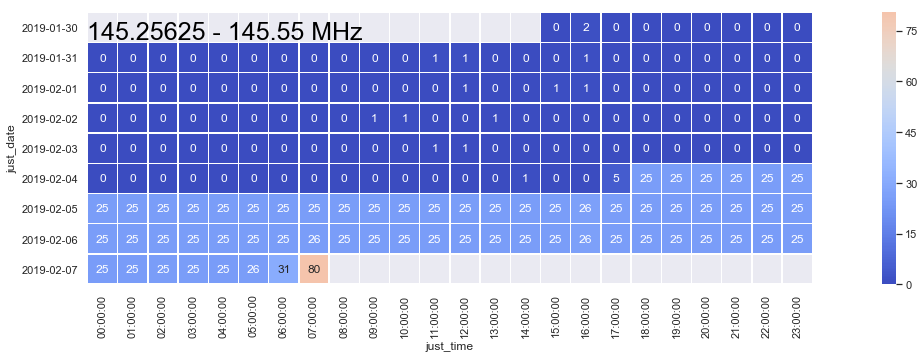

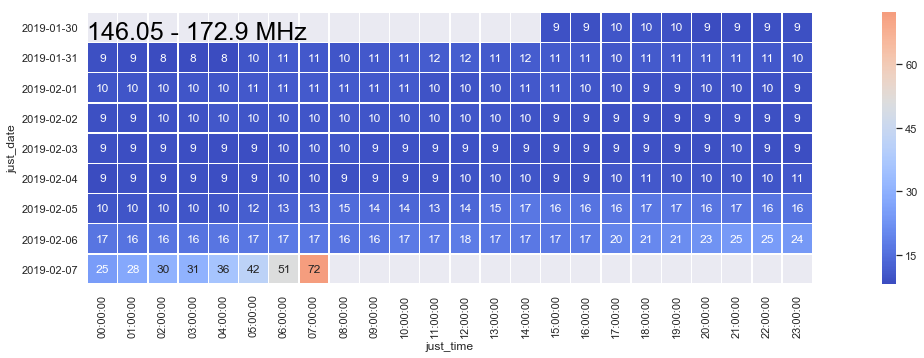

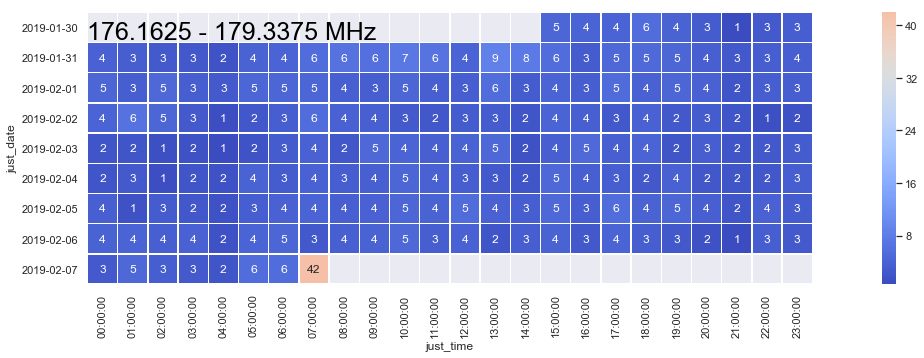

In [65]:
createCharts(10015730)

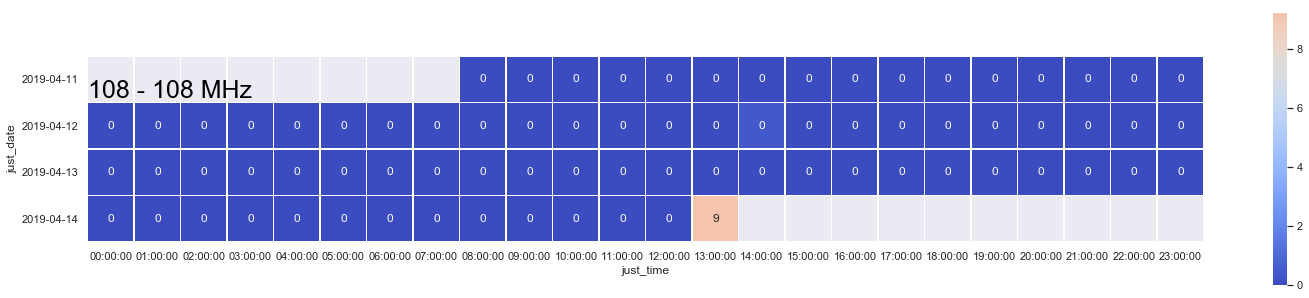

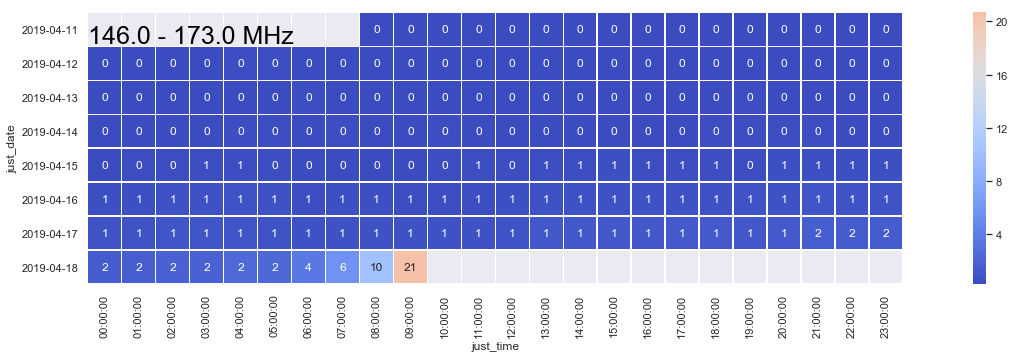

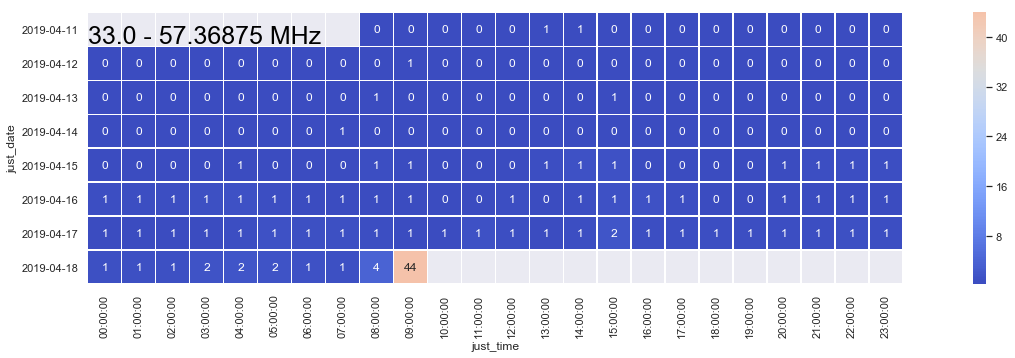

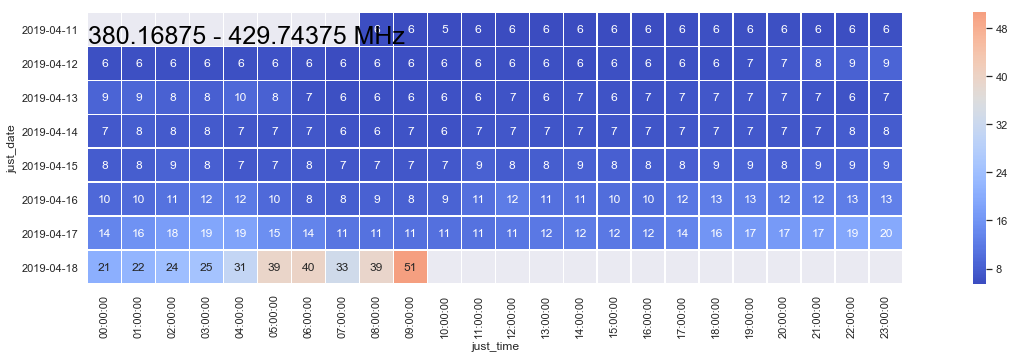

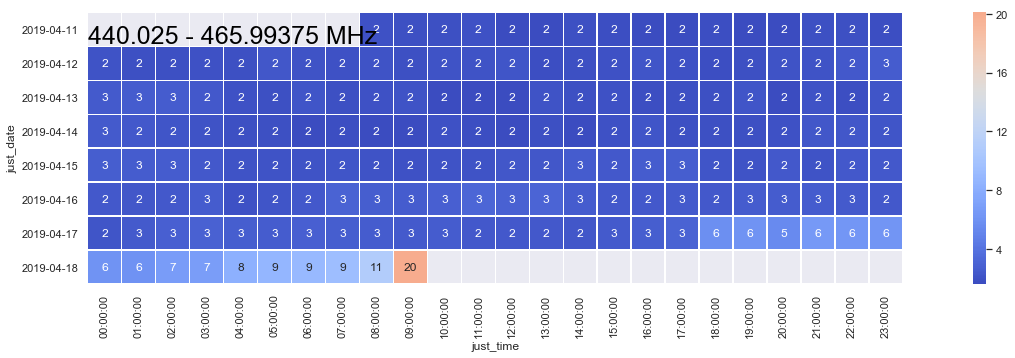

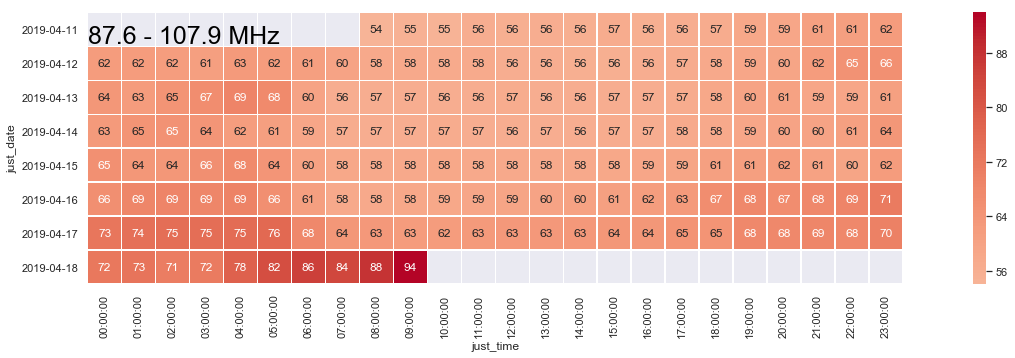

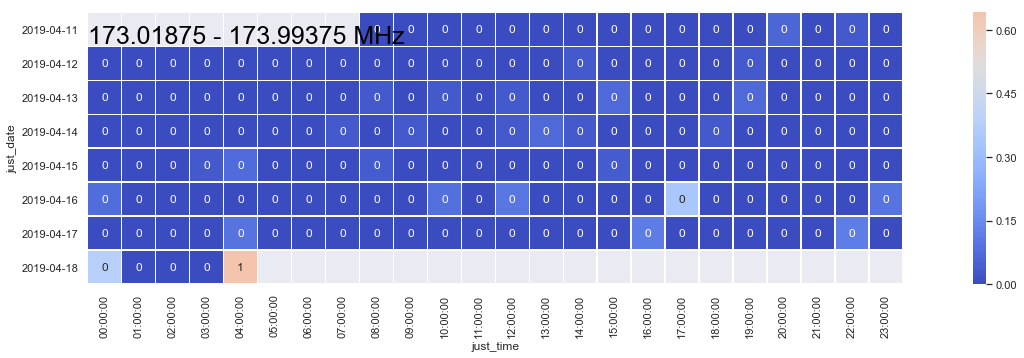

In [66]:
createCharts(10015968)

no grafikiem var vizuāli novērtēt radiosakaru aktivitātes izmaiņu.

Lai pārliecinātos vai dati ir korekti, salīdzināsim mērījumu ciklu izmiaņu laikā

In [67]:
def createCharts1(id):
    id= str(id)
    #10015968
    import pandas as pd
    import os
    import math
    import numpy as np

    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import seaborn as sns
    sns.set()
    
    path = f"{os.getcwd()}/event_{id}/"
    

    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    filelist = os.listdir(path)
    for f_name in filelist:
        filename, file_extension = os.path.splitext(f_name)
        if file_extension == '.csv':
            df=pd.read_csv(path + f_name, na_values=['freq', 'timestamp'], low_memory=False)
            df = df.dropna()
            f1 = df['freq'].min()
            f2 = df['freq'].max()
            df['timestamp'] = df['timestamp'].map(lambda s: pd.to_datetime(s, format='%Y-%m-%d %H:%M:%S', errors='ignore'))
            #print(df.head())
            cycles = df.groupby(pd.Grouper(key='timestamp', freq='60min'))['cycles'].sum()
            counted = df.groupby(pd.Grouper(key='timestamp', freq='60min'))['counted'].sum()
            

            
            df = pd.DataFrame({'timestamp': cycles.index, 'cycles': cycles, 'counted': counted, 'occ': counted/cycles*100})
            df['just_date'] = df['timestamp'].dt.date
            df['just_time'] = df['timestamp'].dt.time
            
            
            #table = pd.pivot_table(df, values='occ', index=['just_date'], columns=['just_time'], aggfunc=np.average)
            table = pd.pivot_table(df, values='cycles', index=['just_date'], columns=['just_time'], aggfunc=np.sum)
            f, ax = plt.subplots(figsize=(25, 5))
            midpoint = (table.values[~np.isnan(table.values)].max() - table.values[~np.isnan(table.values)].min()) *0.8
            heat_plot = sns.heatmap(table, cmap='coolwarm', annot=True, linewidths=.5, fmt=".0f", ax=ax, center=midpoint, square=True)
            plt.text(0,0.9, str(f1) + " - " + str(f2) + " MHz", fontsize = 25, color='Black',)
            fig = heat_plot.get_figure()
            fig.savefig(path + filename + ".png")
            
    



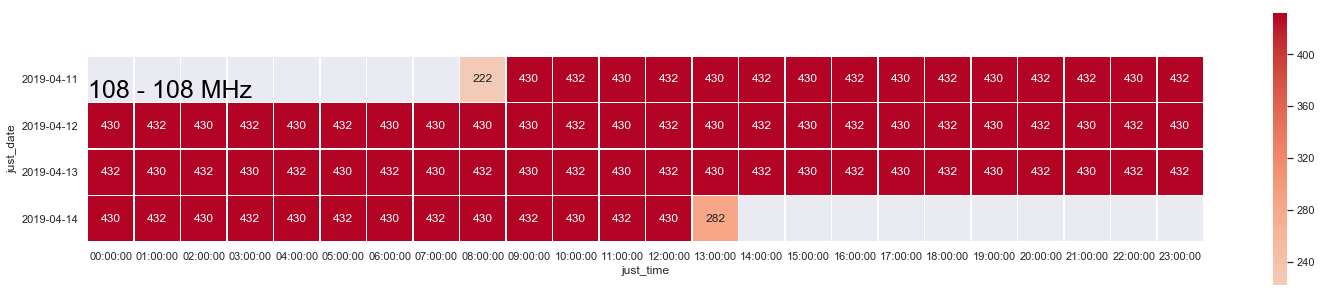

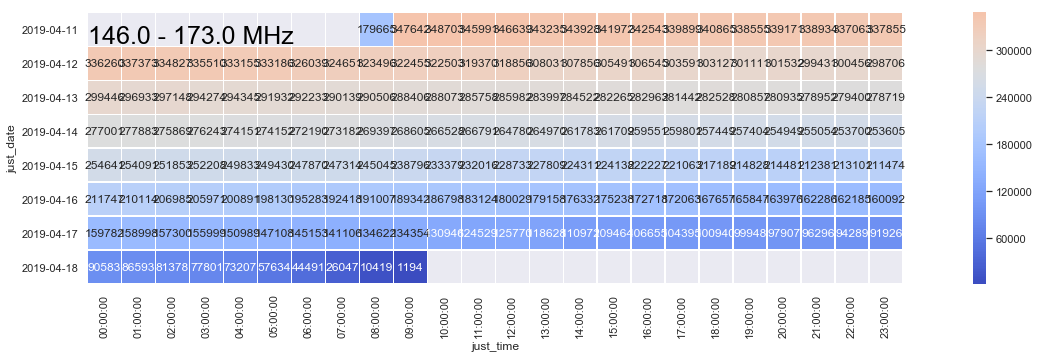

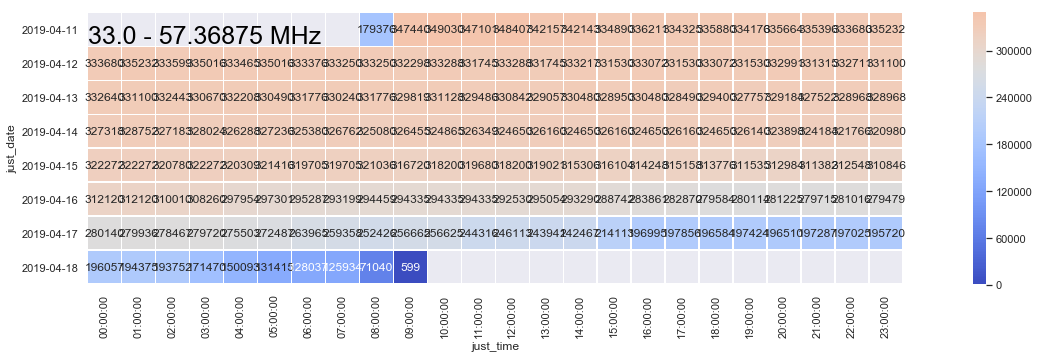

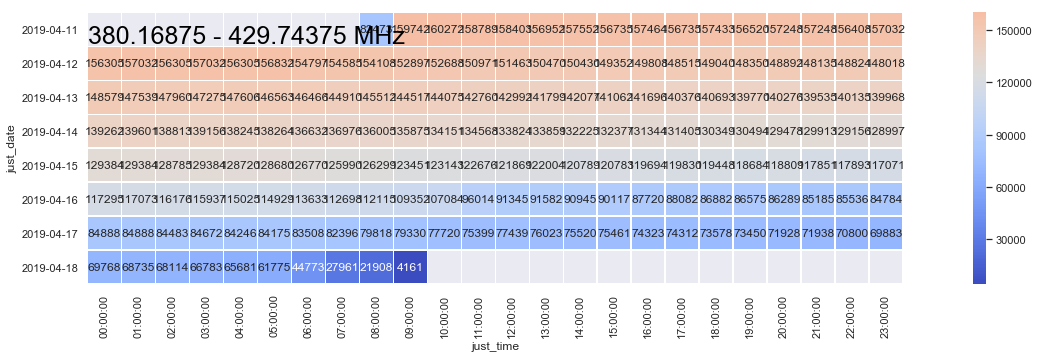

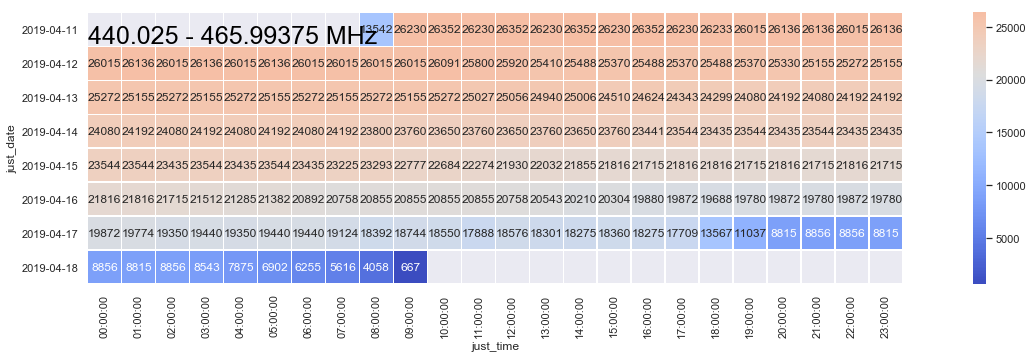

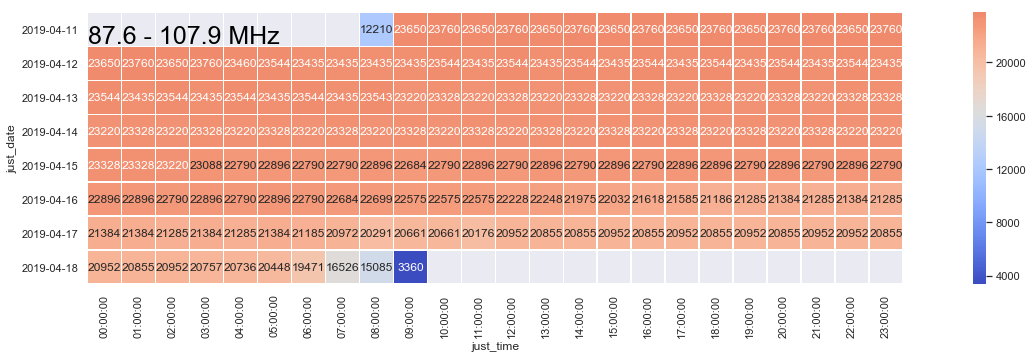

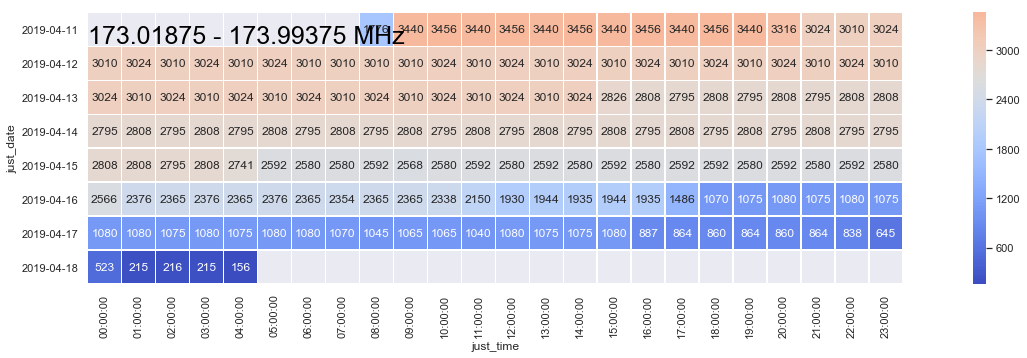

In [68]:
createCharts1(10015968)

Kā redzam, frekvenču diapazona 146-173 MHz grafikā, tad ar laiku samazinās 1 h mērījumu skaits, tas nozīmē ka datos ir kļūda un nav iespējams veikt tālāku datu apstrādi.

Kļūda tika fiksēta mērījumu veikšanas programmatūrā, kura veicot mērījumu un nosūtot datu serverim, atsūtīja datus katrā frekvencē līdz pēdējam fiksētajam signālam, līdz ar to mērījumu dati nebija pilnīgi.
Veicot kļūdas labošanu, atkārtosim datu apstrādi ar jauniem mmērījumiem.

In [71]:
readSkudrFiles(10015996)

C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt
Direktorija vieksmīgi izveidot C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996 
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-21-36_87_94.6.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-21-38_34_423.75.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-21-40_90_414.2375.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-21-41_87_424.775.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-21-42_53_441.1.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homework

C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-23-16_96_424.2375.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-23-18_3_100.3.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-23-19_17_413.2375.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-23-21_23_105.7.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-23-23_43_392.3125.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-23-24_20_449.175.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-23-25_88_423.4.txt
C:\Users\ilmarsl\develpment\git

C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-25-04_83_423.725.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-25-05_89_424.0125.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-25-06_27_391.6125.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-25-08_38_468.075.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-25-09_53_391.4125.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-25-11_87_424.2.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-25-13_69_423.6125.txt
C:\Users\ilmarsl\develpme

C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-26-45_44_423.425.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-26-47_62_393.1125.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-26-48_10_413.55.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-26-49_15_441.175.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-26-51_15_161.85.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-26-53_92_424.45.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-26-54_89_423.8625.txt
C:\Users\ilmarsl\develpment\

C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-28-26_2_423.925.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-28-27_50_394.4125.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-28-29_96_391.2125.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-28-30_22_390.6125.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-28-32_74_393.4625.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-28-34_100_108.txt
C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts\event_10015996\txt\2019-04-26 10-28-35_61_424.325.txt
C:\Users\ilmarsl\develpment

True

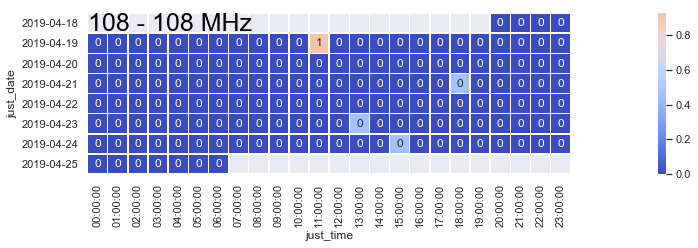

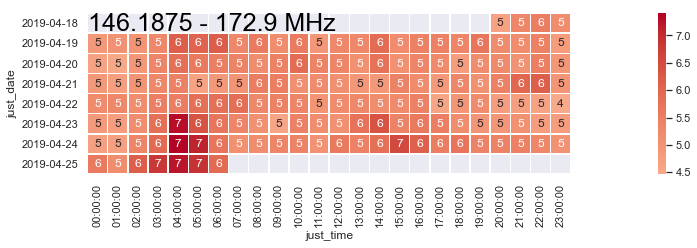

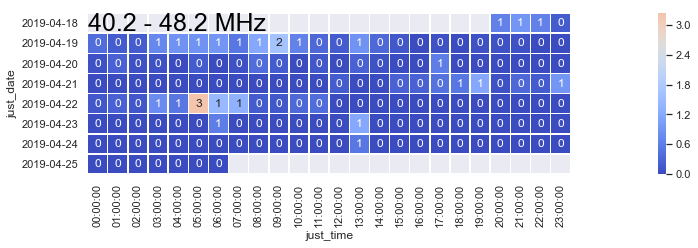

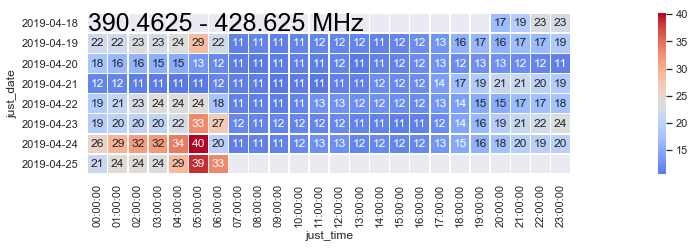

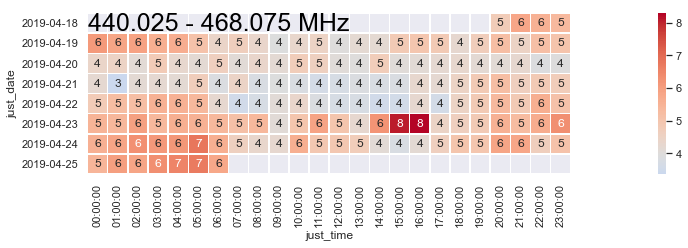

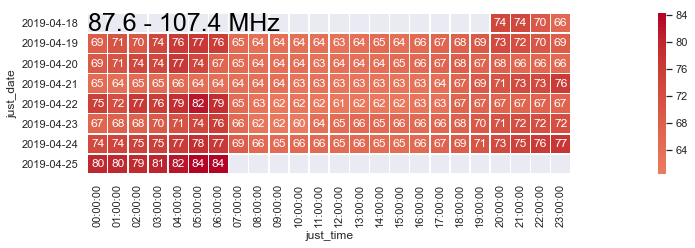

In [76]:
createCharts(10015996)

šīnī gadijumā dati ir korekti un nekadas tendenciozes novirzes nav fiksētas

# 2. Automātiska izmaiņu fiksēšana

Nākamais solis ir izveidot automātisku mehānismu radiosakaru aktivitātes izmaiņu fiksēšanai.


### Anomaliju detektēšan

Veizcot anomāliju detektēšanu visus laika datu sadalīsim ģenerāl kopu pa 3 stundu un 5 MHz platās datu apakškopās,jo skatoties heatmap grafikos redzam ka radiosakaru daudzums (intensitāte) atkartojas dienu uz dienu vienādos laikos.
No rīta ir lielāka intesitāte (kas ir izskaidrojama ar radiofrekvenču tālās izplatības parādību, kā rezultātā tiek uztverti vairāk signālu).

In [3]:
import pandas as pd
import os
import math
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [5]:
df=pd.read_csv('event_10015968/event_10015968_range_380_-_430_MHZ.csv', na_values=['freq', 'timestamp'], low_memory=False)
df = df.dropna()
df.head()

,timestamp,timestamp.1,cycles,counted,freq
0,2019-04-11 08:25:00,2019-04-11 08:25:00,3,0,389.21875
1,2019-04-11 08:30:00,2019-04-11 08:30:00,18,0,389.21875
2,2019-04-11 08:35:00,2019-04-11 08:35:00,18,0,389.21875
3,2019-04-11 08:40:00,2019-04-11 08:40:00,18,0,389.21875
4,2019-04-11 08:45:00,2019-04-11 08:45:00,18,0,389.21875


In [9]:
freq_rounded_u = np.sort(df['freq'].unique());
freq_rounded_u = np.sort(df['freq'].map(lambda s:  math.floor(s/5)*5).unique());

In [17]:
len(timeBins)

9

In [23]:
df_filt=[]
df5={}
timeBins = ['00:00:00', '03:00:00', '06:00:00', '09:00:00', '12:00:00', '15:00:00', '18:00:00', '21:00:00', '24:00:00']
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
for v in freq_rounded_u:
    f1=v
    f2=v+5
    df_filt = df[(f1 <=df['freq']) & (df['freq']<= f2)]
    df_filt['proc'] = df_filt['counted']/df_filt['cycles']
    df_filt.to_csv(f"text{f1}.csv")
    #print(df_filt.groupby('timestamp')['proc'].mean())
    proc = df_filt.groupby('timestamp')['proc'].mean()
    counted = df_filt.groupby('timestamp')['counted'].sum()
    cycles = df_filt.groupby('timestamp')['cycles'].sum()
    times = proc.index.map(lambda s: s[-8:])
    
    #print(proc)
    
    df_new = pd.DataFrame({'timestamp': proc.index, 'proc': proc, 'counted': counted, 'cycles': cycles, 'times': times })
    df5[f1]={}
    ti=0
    for tb in timeBins:
        ti+=1
        if len(timeBins) == ti:
            break
        df_new1= df_new[(tb <=df_new['times']) & (df_new['times'] <= timeBins[ti])]
        df5[f1][ti] = df_new1
            
    ''' 
    df_new_1 = df_new[('00:00:00' <=df_new['times']) & (df_new['times'] <= '03:00:00')]
    df5[f1][1] = df_new_1
    df_new_2 = df_new[('03:00:00' <=df_new['times']) & (df_new['times'] <= '06:00:00')]
    df5[f1][2] = df_new_2
    df_new_3 = df_new[('06:00:00' <=df_new['times']) & (df_new['times'] <= '09:00:00')]
    df5[f1][3] = df_new_3
    '''

#df5.keys()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [25]:
df5[390].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])

Iegsim histogrammas dažādos laika posmos un frekvenču diapazonos

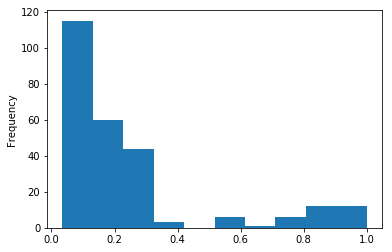

In [37]:
df5[380][1]['proc'].plot(kind='hist')

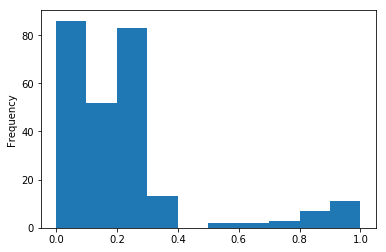

In [38]:
df5[380][2]['proc'].plot(kind='hist')

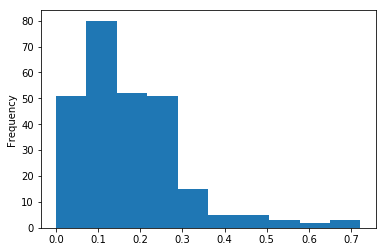

In [39]:
df5[380][3]['proc'].plot(kind='hist')

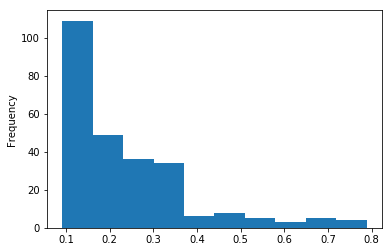

In [32]:
df5[390][2]['proc'].plot(kind='hist')

kā redzams ne visās statistikas apakškopās ir vienmērīgs sadalījums

Anomāliju biloteka:

In [40]:

 # Importing KNN module from PyOD
from pyod.models.knn import KNN

In [48]:
# Segregate the salary values and the class labels 
X = df5[390][2].proc.values.reshape(-1,1)

In [49]:
# Train kNN detector
clf = KNN(contamination=0.02, n_neighbors=5)
clf.fit(X)

KNN(algorithm='auto', contamination=0.02, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [50]:
# Get the prediction labels of the training data
y_train_pred = clf.labels_ 

# Outlier scores
y_train_scores = clf.decision_scores_  

lai pārbaudītu kā algoritms strādā izmēģinasim ar vērtībām no 0 līdz 100 ar 2% soli


In [51]:
def checkValue(val):
    X_test = np.array([[val]])
    clf.predict(X_test)
    prediction = clf.predict(X_test)
    if prediction[0] == 1:
        print(f"{val} ir anomalija")
    else:
        print(f"{val} ir OK")

In [52]:
mylist = list(range(0, 100, 2))
for l in mylist:
    checkValue(l/100)

0.0 ir anomalija
0.02 ir anomalija
0.04 ir anomalija
0.06 ir OK
0.08 ir OK
0.1 ir OK
0.12 ir OK
0.14 ir OK
0.16 ir OK
0.18 ir OK
0.2 ir OK
0.22 ir OK
0.24 ir OK
0.26 ir OK
0.28 ir OK
0.3 ir OK
0.32 ir OK
0.34 ir OK
0.36 ir OK
0.38 ir OK
0.4 ir OK
0.42 ir OK
0.44 ir OK
0.46 ir OK
0.48 ir OK
0.5 ir OK
0.52 ir OK
0.54 ir OK
0.56 ir OK
0.58 ir OK
0.6 ir OK
0.62 ir OK
0.64 ir OK
0.66 ir OK
0.68 ir OK
0.7 ir OK
0.72 ir anomalija
0.74 ir anomalija
0.76 ir anomalija
0.78 ir anomalija
0.8 ir anomalija
0.82 ir anomalija
0.84 ir anomalija
0.86 ir anomalija
0.88 ir anomalija
0.9 ir anomalija
0.92 ir anomalija
0.94 ir anomalija
0.96 ir anomalija
0.98 ir anomalija


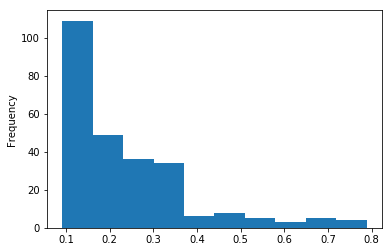

In [53]:
df5[390][2]['proc'].plot(kind='hist')

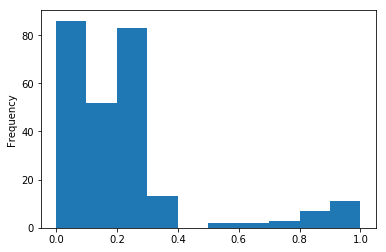

In [54]:
#izmēģināsim datu kopu kur sadalījumā ir tukšus starpā
df5[380][2]['proc'].plot(kind='hist')

In [58]:
# Segregate the salary values and the class labels 
X = df5[380][2].proc.values.reshape(-1,1)
# Train kNN detector
clf = KNN(contamination=0.04, n_neighbors=10)
clf.fit(X)
# Get the prediction labels of the training data
y_train_pred = clf.labels_ 

# Outlier scores
y_train_scores = clf.decision_scores_  
mylist = list(range(0, 100, 2))
for l in mylist:
    checkValue(l/100)

0.0 ir OK
0.02 ir OK
0.04 ir OK
0.06 ir OK
0.08 ir OK
0.1 ir OK
0.12 ir OK
0.14 ir OK
0.16 ir OK
0.18 ir OK
0.2 ir OK
0.22 ir OK
0.24 ir OK
0.26 ir OK
0.28 ir OK
0.3 ir OK
0.32 ir OK
0.34 ir OK
0.36 ir OK
0.38 ir anomalija
0.4 ir anomalija
0.42 ir anomalija
0.44 ir anomalija
0.46 ir anomalija
0.48 ir anomalija
0.5 ir anomalija
0.52 ir anomalija
0.54 ir anomalija
0.56 ir anomalija
0.58 ir anomalija
0.6 ir anomalija
0.62 ir anomalija
0.64 ir anomalija
0.66 ir anomalija
0.68 ir anomalija
0.7 ir anomalija
0.72 ir anomalija
0.74 ir anomalija
0.76 ir anomalija
0.78 ir anomalija
0.8 ir anomalija
0.82 ir anomalija
0.84 ir anomalija
0.86 ir anomalija
0.88 ir anomalija
0.9 ir OK
0.92 ir OK
0.94 ir OK
0.96 ir OK
0.98 ir OK


šinī gadijumā acim redzami ka algorits nespēj vienozīmīgi fiksēt anomālijas, kā arī mums vajadzētu novērtēt anomaliju skalārā lielumā

kā nakamais solis mēģināsim fiksēt anomāliju izmantojot laika datus, meklējot novizri no periodiskiem mērījumiem.

In [59]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 42C9-F436

 Directory of C:\Users\ilmarsl\develpment\gituHub\RCS_Data_Analysis_Python_2019_homeworks\projekts

02.05.2019  15:10    <DIR>          .
02.05.2019  15:10    <DIR>          ..
25.04.2019  15:12    <DIR>          .ipynb_checkpoints
25.04.2019  15:02    <DIR>          event_10015730
02.05.2019  10:03    <DIR>          event_10015968
02.05.2019  12:53    <DIR>          event_10015996
25.04.2019  15:33                96 mysql_config.json
02.05.2019  15:10         1 846 538 projekts.ipynb
25.04.2019  11:02        10 559 171 sql_event_10015730_5_min.csv
02.05.2019  14:54         1 011 849 text380.csv
02.05.2019  14:54         6 934 108 text385.csv
02.05.2019  14:54        11 282 428 text390.csv
02.05.2019  14:54         1 072 052 text395.csv
02.05.2019  14:54         6 265 073 text400.csv
02.05.2019  14:54        13 905 616 text405.csv
02.05.2019  14:54         8 254 194 text410.csv
02.05.2019  14:54         4 259 613 text415

### Laika datu anomāliju fiksēšana

In [61]:
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
time_series_df_raw=pd.read_csv('text390.csv')
time_series_df_raw.head()

,Unnamed: 0,timestamp,timestamp.1,cycles,counted,freq,proc
0,96415,2019-04-11 08:25:00,2019-04-11 08:25:00,3,0,394.58125,0.0
1,96416,2019-04-11 08:30:00,2019-04-11 08:30:00,18,0,394.58125,0.0
2,96417,2019-04-11 08:35:00,2019-04-11 08:35:00,18,0,394.58125,0.0
3,96418,2019-04-11 08:40:00,2019-04-11 08:40:00,18,0,394.58125,0.0
4,96419,2019-04-11 08:45:00,2019-04-11 08:45:00,18,0,394.58125,0.0


In [62]:
time_series_df_raw.describe()

,Unnamed: 0,cycles,counted,freq,proc
count,1.647710e+05,164771.000000,164771.000000,164771.000000,164771.000000
mean,7.306573e+05,17.932081,2.662083,392.551573,0.148489
std,3.209246e+05,0.470911,5.729985,1.398568,0.319393
min,9.641500e+04,1.000000,0.000000,390.000000,0.000000
25%,4.637785e+05,18.000000,0.000000,391.412500,0.000000
50%,7.804620e+05,18.000000,0.000000,392.312500,0.000000
75%,1.022168e+06,18.000000,0.000000,393.412500,0.000000
max,1.142751e+06,18.000000,18.000000,394.987500,1.000000


Tā ka šajā datu kopā ir 164771 mērījums  (sadalīts pa 5 min intervāliem), tad lai apstrādātu šādus datus, tas prasīs daudz laika, bet šos aprēķinus vajag iegūt pēc iespējas ātrāk, tad pārrēķināsim 1 h gariem intervāliem

In [66]:
#proc = time_series_df_raw.groupby('timestamp')['proc'].mean()
time_series_df_raw['timestamp'] = time_series_df_raw['timestamp'].map(lambda s: pd.to_datetime(s, format='%Y-%m-%d %H:%M:%S', errors='ignore'))
proc = time_series_df_raw.groupby(pd.Grouper(key='timestamp', freq='60min'))['proc'].mean()
proc.head()

timestamp
2019-04-11 08:00:00    0.094771
2019-04-11 09:00:00    0.097584
2019-04-11 10:00:00    0.095752
2019-04-11 11:00:00    0.094416
2019-04-11 12:00:00    0.097004
Freq: 60T, Name: proc, dtype: float64

In [67]:
time_series_df = pd.DataFrame()
time_series_df = pd.DataFrame({'load_date': pd.to_datetime(proc.index, format='%Y-%m-%d %H:%M:%S'), 'actuals': proc})
time_series_df = time_series_df.sort_values(by="load_date")
time_series_df = time_series_df.reset_index(drop=True)
time_series_df.head()

,load_date,actuals
0,2019-04-11 08:00:00,0.094771
1,2019-04-11 09:00:00,0.097584
2,2019-04-11 10:00:00,0.095752
3,2019-04-11 11:00:00,0.094416
4,2019-04-11 12:00:00,0.097004


In [68]:
time_series_df.describe()

,actuals
count,170.000000
mean,0.156645
std,0.098323
min,0.089338
25%,0.100299
50%,0.125216
75%,0.175496
max,0.686246


šinī gadijumā jau ir <b>170</b> ieraksti

pēdējos 24 (1 diena) ierakstus izmantosim kā testa datus

In [71]:
actual_vals = time_series_df.actuals.values
actual_log = np.log10(actual_vals)

In [75]:
len(train)

146

In [72]:
import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
train, test = actual_vals[0:-24], actual_vals[-24:]
train_log, test_log = np.log10(train), np.log10(test)


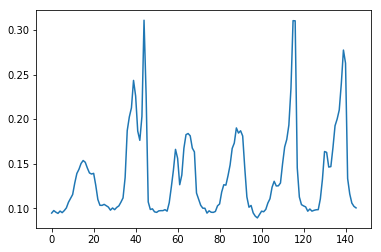

In [73]:
#treniņa dati
pyplot.plot(train,label='Actuals')

In [78]:
my_order = (1, 0, 0)
my_seasonal_order = (0, 1, 1, 24) # 24 h - atkārtošanas periods

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



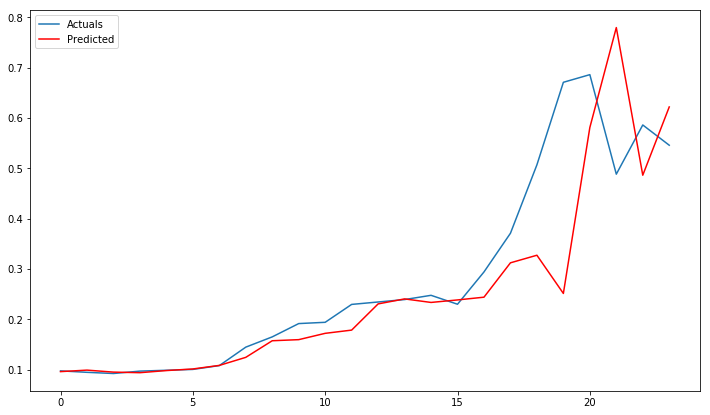

In [77]:
history = [x for x in train_log]
predictions = list()
predict_log=list()
for t in range(len(test_log)):
    model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
   # print('predicted=%f, expected=%f' % (output[0], obs))
#error = math.sqrt(mean_squared_error(test_log, predict_log))
#print('Test rmse: %.3f' % error)
# plot
figsize=(12, 7)
plt.figure(figsize=figsize)
pyplot.plot(test,label='Actuals')
pyplot.plot(predictions, color='red',label='Predicted')
pyplot.legend()
pyplot.show()

### Rezultāts!
iegūstam radiofrekveņču lietošanas aktivites prognozi 5 MHz paltā diapazonā (šinī gadijumā frekvenču diapazonā 390-395 MHz)

### Nākamie soļi
1. optimizēt prognozes algoritma koeficientus: *order* un *seasonal_order*
2. aprēķināt kļūdu 
3. izviedot servera risinājumu, kurš:
 - saglabā saņemtos datus no monitoringa programmas;
 - izmantojot iepriekšējos rezultātus veic prognozes kļūdas aprēķinu;
 - saglabā kļūdas koefientu;
 - izveidot web saskarni (dashboard), kur uzrādās kļūdas kooeficients dažādās mērījuma vietās.